# Latent Semantic Analysis (LSA)

This notebook is for developing, not implementing a solution.

*Current State*
- Preprocessing was performed for a Bag-of-upto-Ngrams with TF-IDF representation
- This type of representation still suffers from the curse of dimensionality, best accuracies achieved with a Bag-of-upto-Trigram TF-IDF training subset of 120k documents (Tweets) and 100k terms
- LSA, in particular, matrix decomposition using SVD, can be used to reduce a document-term matrix to a document-component (or topic) matrix

*Results*
- SVD did not seem to improve accuracy, speed, or reduce the size of the data
- Unclear whether I'm not implementing it correctly or it's just not useful given this type of problem and goal, maybe it is really meant to help interpret the data, not improve accuracy or prediction speed

---

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd

import cleanup_module as Cmod

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.decomposition import TruncatedSVD

### Sample 10% of the training data for POC

In [2]:
# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# sample for dev
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# create array
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

In [3]:
X_array.shape, y_array.shape

((119747,), (119747,))

### Preprocess Bag-of-upto-Trigrams with 100,000 terms

Using `sublinear_tf=True, use_idf=True` as recommended in [docs](https://scikit-learn.org/stable/modules/decomposition.html#lsa): 

*In particular, sublinear scaling and inverse document frequency should be turned on (`sublinear_tf=True, use_idf=True`) to bring the feature values closer to a Gaussian distribution, compensating for LSA’s erroneous assumptions about textual data.*

In [4]:
pipe = Pipeline([('counter', Cmod.DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=100000)),
                 ('tfidf', TfidfTransformer(sublinear_tf=True, use_idf=True))]) 

In [5]:
start_time = time.time()

X_train_transformed = pipe.fit_transform(X_array)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 2 min 39 sec


In [6]:
X_train_transformed

<119747x100001 sparse matrix of type '<class 'numpy.float64'>'
	with 2687589 stored elements in Compressed Sparse Row format>

### SVD

Point of departure: [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/). 

Consulted Prof. Steve Brunton's [YouTube lecture series](https://www.youtube.com/playlist?list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv) and [Data-Driven Science and Engineering book](https://www.amazon.com/Data-Driven-Science-Engineering-Learning-Dynamical/dp/1108422098). 

Using sklearn's **TruncatedSVD** class, "arpack" algorithm. The "randomized" algorithm takes longer and arrives at the same result as far as I could tell, here are the relevant parts of the docs:

[(source)](https://github.com/scikit-learn/scikit-learn/blob/0fb307bf3/sklearn/decomposition/_truncated_svd.py#L24)
```
    def fit_transform(self, X, y=None):
        """Fit LSI model to X and perform dimensionality reduction on X.
        
        [...]
        
        if self.algorithm == "arpack":
            U, Sigma, VT = svds(X, k=self.n_components, tol=self.tol)
            # svds doesn't abide by scipy.linalg.svd/randomized_svd
            # conventions, so reverse its outputs.
            Sigma = Sigma[::-1]
            U, VT = svd_flip(U[:, ::-1], VT[::-1])

        elif self.algorithm == "randomized":
            k = self.n_components
            n_features = X.shape[1]
            if k >= n_features:
                raise ValueError("n_components must be < n_features;"
                                 " got %d >= %d" % (k, n_features))
            U, Sigma, VT = randomized_svd(X, self.n_components,
                                          n_iter=self.n_iter,
                                          random_state=random_state)
        else:
            raise ValueError("unknown algorithm %r" % self.algorithm)

        self.components_ = VT

        # Calculate explained variance & explained variance ratio
        X_transformed = U * Sigma
        
        [...]
        
        self.singular_values_ = Sigma  # Store the singular values.

        return X_transformed

    def transform(self, X):
        """Perform dimensionality reduction on X.
        [...]
        X = check_array(X, accept_sparse=['csr', 'csc'])
        check_is_fitted(self)
        return safe_sparse_dot(X, self.components_.T)
```                                          

**DIFFERENCE**: 
* Trying out 300 components AND passing in the transpose matrix, i.e. a term-document freq matrix.

In [9]:
svd_model = TruncatedSVD(n_components=300,
                         algorithm='arpack',
                         n_iter=600, 
                         random_state=42)

In [10]:
start_time = time.time()

svd_model.fit(X_train_transformed.T)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 2 min 3 sec


In [11]:
svd_model.n_features_in_ # terms, the Vt matrix becomes the new training data, Vt = document perspective

119747

In [12]:
len(svd_model.components_)

300

In [13]:
len(svd_model.components_[0])

119747

In [24]:
svd_model.components_.shape # is this the Vt matrix from doc's perspective? I believe so, short and wide 
# YES, code line 187: self.components_ = VT

(300, 119747)

In [23]:
svd_model.singular_values_.shape

(300,)

In [25]:
svd_model.components_.T.shape # V is the new training data

(119747, 300)

In [30]:
print(svd_model.components_.T[:10, :3]) # first three docs, first three Vs

[[ 2.53703657e-03 -1.99239782e-03  3.22318744e-04]
 [ 3.81921437e-03 -1.89790388e-03 -3.80373012e-03]
 [ 2.15505053e-03 -1.11103170e-03 -2.06357035e-03]
 [ 2.39791899e-03  6.30760008e-04 -1.70887833e-03]
 [ 2.61821341e-03 -1.68866092e-05  2.26100328e-03]
 [ 2.44470532e-03 -1.91515322e-03  1.65304505e-03]
 [ 2.72778923e-03  4.90533284e-04  6.06077805e-03]
 [ 3.11451949e-03  4.68835601e-04  3.37002659e-03]
 [ 2.38310922e-03 -1.27561431e-03 -8.16084430e-05]
 [ 2.34953457e-03 -1.92677642e-03  1.31423487e-03]]


In [31]:
import sys 

sys.getsizeof(svd_model.components_.T) # small, no need to make it sparse

112

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, svd_model.components_.T, 
                        y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)

print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.0s remaining:    9.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.1s finished


accuracy: 0.7520 (+/- 0.0017)


In [16]:
from sklearn.utils.extmath import safe_sparse_dot

# transform method in sklearn's docs (see above)
svd_model_transf = safe_sparse_dot(X_train_transformed.T, svd_model.components_.T)

# fitting and transforming as above can also be done together
# svd_model_transf = svd_model.fit_transform(X_train_transformed)

svd_model_transf.shape 

(100001, 300)

We're not done here since the resulting `svd_model_transf` is a numpy array not a sparse matrix - notice the size difference:

In [14]:
import sys

sys.getsizeof(X_train_transformed), sys.getsizeof(svd_model_transf)

(56, 957976112)

In [15]:
from scipy.sparse import csr_matrix

svd_model_csr = csr_matrix(svd_model_transf, shape=(svd_model_transf.shape))

In [16]:
sys.getsizeof(svd_model_csr)

56

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, svd_model_csr, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   50.0s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   52.2s finished


accuracy: 0.7754 (+/- 0.0013)


In [33]:
# compare to original X_train_transformed
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.0s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.2s finished


accuracy: 0.8013 (+/- 0.0015)


### Plotting singular values

The idea is to help see whether the full 1000 components are needed or we can get away with using a smaller subset - the results below show that despite a slightly faster training time (compared to the full 1000 components not the original data), the hit in accuracy isn't worth dumping those components that have "low energy" or seem to explain less of the variance in the data.

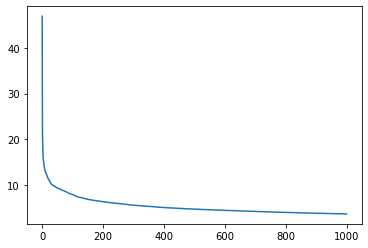

In [19]:
import matplotlib.pyplot as plt

plt.plot(svd_model.singular_values_)
plt.show()

Trying out first 300 to compare speeds.

In [20]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, svd_model_csr[:,:300], y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


accuracy: 0.7532 (+/- 0.0020)


---

Note: avoid Naive Bayes on SVD since it implies strong independence between variables.

Quoting the [Analytics Vidhya Tutorial](https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/) ~

"*Apart from LSA, there are other advanced and efficient topic modeling techniques such as Latent Dirichlet Allocation (LDA) and lda2Vec. We have a wonderful article on LDA which you can check out [here](https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/). lda2vec is a much more advanced topic modeling which is based on word2vec word embeddings.*"